# <a id='toc1_'></a>[Analysis of GPU Jobs that Requested and Used VRAM](#toc0_)
This notebook generates the analysis for jobs that requested some VRAM and run on partitions that their type is GPU and some GPU VRAM is used. It looks at these jobs, corresponding users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Analysis of GPU Jobs that Requested and Used VRAM](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Data Digestion and Preprocessing](#toc1_2_)    
  - [Narrowing Dataset Down to the Relevant Partition](#toc1_3_)    
  - [Generate Baseline Metrics](#toc1_4_)    
  - [Job-Level Analysis](#toc1_5_)    
      - [Find most inefficient jobs with no VRAM constraints based on `requested_vram_efficiency_score`](#toc1_5_1_1_)    
    - [Generate all hoarding analysis metrics for jobs:](#toc1_5_2_)    
      - [Find most inefficient jobs hoarding node RAM based on `ram_hoarding_fraction_diff`](#toc1_5_2_1_)    
      - [Find most inefficient jobs hoarding CPU cores based on `core_hoarding_fraction_diff`](#toc1_5_2_2_)    
  - [User-Level Analysis](#toc1_6_)    
    - [Find Inefficient Users based on `avg_requested_vram_efficiency_score`](#toc1_6_1_)    
    - [Find Inefficient Users based on EV(alloc_vram_efficiency)](#toc1_6_2_)    
    - [Generate all hoarding analysis metrics for users:](#toc1_6_3_)    
      - [Find most inefficient users hoarding node RAM based on `expected_value_ram_hoarding_fraction_diff`](#toc1_6_3_1_)    
      - [Find most inefficient users hoarding CPU cores based on `expected_value_core_hoarding_fraction_diff`](#toc1_6_3_2_)    
  - [PI Group Analysis](#toc1_7_)    
      - [Find Inefficient PIs based on `avg_requested_vram_efficiency_score`](#toc1_7_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [ ]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [ ]:
project_root = Path.cwd().resolve().parent.parent
print(f"Project root: {project_root.name}")

Project root: ds4cg-job-analytics


In [ ]:
# Automatically reload modules before executing code (set this up BEFORE imports)
%load_ext autoreload
%autoreload 2

# Add project root to sys.path for module imports
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.analysis import ResourceHoarding
from src.visualization import (
    JobsWithMetricsVisualizer,
    UsersWithMetricsVisualizer,
    PIGroupsWithMetricsVisualizer,
)
from src.config.enum_constants import ResourceHoardingDataFrameNameEnum
from src.config.paths import (
    JOBS_VISUALIZATION_DATA_DIR,
    USERS_VISUALIZATION_DATA_DIR,
    PI_GROUPS_VISUALIZATION_DATA_DIR,
)
from src.utilities import load_and_preprocess_jobs

## <a id='toc1_2_'></a>[Data Digestion and Preprocessing](#toc0_)

In [ ]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = load_and_preprocess_jobs(
    db_path=Path(project_root) / "data/slurm_data.db",
    table_name="Jobs",
    anonymize=True,
)
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.


  processed_data = Preprocess().preprocess_data(jobs_df, apply_filter=False, anonymize=anonymize)


Found 42 records with errors. Reporting them to a summary file preprocessing_errors.log.
Disconnected from slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
354992,41012953,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,176635904.0,99.950012,0 days 00:35:47,11,<NA>,11,11
354991,41012951,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172380160.0,99.964767,0 days 00:36:02,11,<NA>,11,11
354990,41012949,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171646976.0,99.970505,0 days 00:37:20,11,<NA>,11,11
354989,41012881,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171102208.0,99.945618,0 days 00:36:56,11,<NA>,11,11
354988,41012877,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171216896.0,99.963730,0 days 00:36:48,11,<NA>,11,11
354987,41012873,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,184594432.0,99.952988,0 days 00:33:03,11,<NA>,11,11
354986,41012869,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,160063488.0,99.963593,0 days 00:34:07,11,<NA>,11,11
354985,41012867,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171073536.0,99.922615,0 days 00:32:46,11,<NA>,11,11
354984,41012866,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172363776.0,99.959511,0 days 00:32:19,11,<NA>,11,11
354983,41012864,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,173252608.0,99.921066,0 days 00:33:00,11,<NA>,11,11


(660508, 31)


## <a id='toc1_3_'></a>[Narrowing Dataset Down to the Relevant Partition](#toc0_)


In [ ]:
analyzer = ResourceHoarding(jobs_df=preprocessed_jobs_df)

In [ ]:
filtered_jobs = analyzer.filter_jobs_for_analysis(
    gpu_mem_usage_filter={"min": 0, "inclusive": False}, requested_vram_filter={"min": 0, "inclusive": False}
)

## <a id='toc1_4_'></a>[Generate Baseline Metrics](#toc0_)

In [ ]:
metrics_dict = analyzer.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict["jobs_with_efficiency_metrics"]
users_with_metrics = metrics_dict["users_with_efficiency_metrics"]
pi_accounts_with_metrics = metrics_dict["pi_accounts_with_efficiency_metrics"]

## <a id='toc1_5_'></a>[Job-Level Analysis](#toc0_)

In [ ]:
# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(jobs_with_metrics.head(5))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
354910,41012486,<NA>,-1,interactive,False,shell,account_177,user_211,"['sm_80', 'vram80']",short,COMPLETED,SUCCESS,2025-08-13 05:48:44,2025-08-13 05:48:45,0 days 00:31:51,0 days 01:00:00,gpu,[uri-gpu009],1,{'h100': 1},2.090231e+10,95.0,3.847968,0 days 00:00:01,80,<NA>,80,80,0.530833,42.466667,19.466797,0.243335,0.243335,-60.018834,-60.018834,23.698650,40.0,0.592466,12
354850,41011725,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.501327e+10,97.0,23.800268,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.921875,0.873372,0.873372,-19.520095,-19.520095,29.969662,30.0,0.998989,2
354849,41011724,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.504682e+10,97.0,23.747896,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.953125,0.874023,0.874023,-19.412664,-19.412664,29.969715,30.0,0.998991,2
354848,41011723,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.642256e+10,97.0,21.256886,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,43.234375,0.900716,0.900716,-15.075501,-15.075501,29.969894,30.0,0.998996,2
354847,41011722,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.457916e+10,97.0,21.234501,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.517578,0.864950,0.86495,-20.917259,-20.917259,29.969879,30.0,0.998996,2


Jobs found: 326050


#### <a id='toc1_5_1_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `requested_vram_efficiency_score`](#toc0_)

Minimum value for requested_vram_efficiency_score: -13304988.074955102


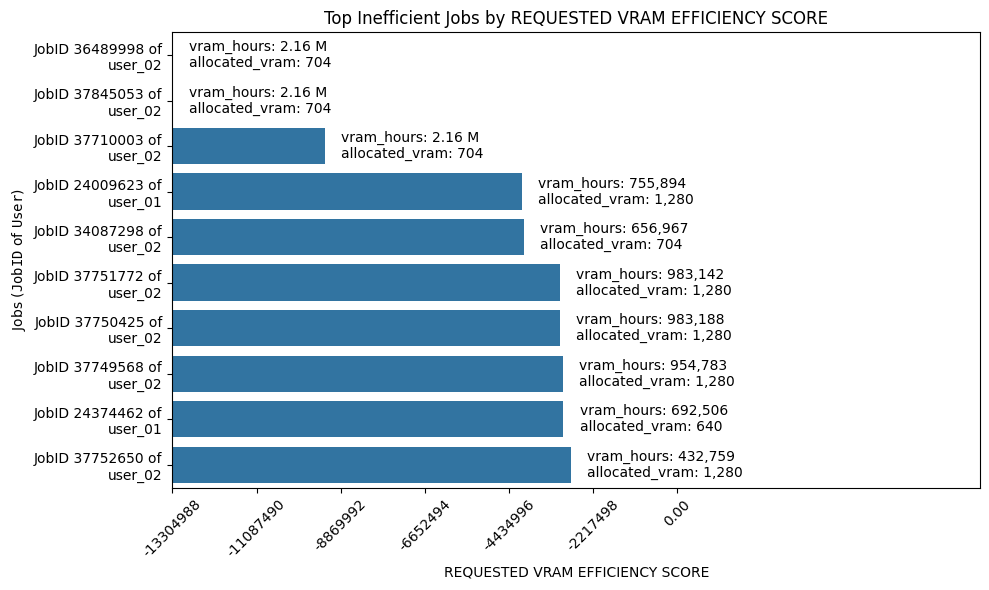

In [ ]:
inefficient_jobs_req_vram_score = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.JOBS,
    sorting_key="requested_vram_efficiency_score",
    ascending=True,  # Sort by requested_vram_efficiency_score in ascending order
    filter_criteria={
        "alloc_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
    },
)
# Plot top inefficient jobs by requested VRAM efficiency score, with VRAM-hours as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_req_vram_score.head(10))
jobs_with_metrics_visualizer.visualize(
    output_dir_path=JOBS_VISUALIZATION_DATA_DIR,
    column="requested_vram_efficiency_score",
    bar_label_columns=["vram_hours", "allocated_vram"],
    figsize=(10, 6),
    anonymize=True,
)

### <a id='toc1_5_2_'></a>[Generate all hoarding analysis metrics for jobs:](#toc0_)

In [ ]:
memory_hoarding_jobs = analyzer.calculate_node_resource_hoarding_for_jobs(filtered_jobs)

# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(memory_hoarding_jobs.head(5))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")

print(f"Jobs found: {len(memory_hoarding_jobs)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count,total_ram_of_nodes_gib,total_gpu_count_of_nodes,gpu_count_fraction,allocated_ram_fraction,ram_hoarding_fraction_diff,total_cores_of_nodes,allocated_cores_fraction,core_hoarding_fraction_diff
354910,41012486,<NA>,-1,interactive,False,shell,account_177,user_211,"['sm_80', 'vram80']",short,COMPLETED,SUCCESS,2025-08-13 05:48:44,2025-08-13 05:48:45,0 days 00:31:51,0 days 01:00:00,gpu,[uri-gpu009],1,{'h100': 1},2.090231e+10,95.0,3.847968,0 days 00:00:01,80,<NA>,80,80,0.530833,42.466667,19.466797,0.243335,0.243335,-60.018834,-60.018834,23.698650,40.0,0.592466,12,1000,4,0.25,0.04,-0.21,64,0.1875,-0.0625
354850,41011725,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.501327e+10,97.0,23.800268,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.921875,0.873372,0.873372,-19.520095,-19.520095,29.969662,30.0,0.998989,2,500,4,0.25,0.06,-0.19,32,0.0625,-0.1875
354849,41011724,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.504682e+10,97.0,23.747896,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.953125,0.874023,0.874023,-19.412664,-19.412664,29.969715,30.0,0.998991,2,500,4,0.25,0.06,-0.19,32,0.0625,-0.1875
354848,41011723,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.642256e+10,97.0,21.256886,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,43.234375,0.900716,0.900716,-15.075501,-15.075501,29.969894,30.0,0.998996,2,500,4,0.25,0.06,-0.19,32,0.0625,-0.1875
354847,41011722,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.457916e+10,97.0,21.234501,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.517578,0.864950,0.86495,-20.917259,-20.917259,29.969879,30.0,0.998996,2,500,4,0.25,0.06,-0.19,32,0.0625,-0.1875


Jobs found: 326050


#### <a id='toc1_5_2_1_'></a>[Find most inefficient jobs hoarding node RAM based on `ram_hoarding_fraction_diff`](#toc0_)

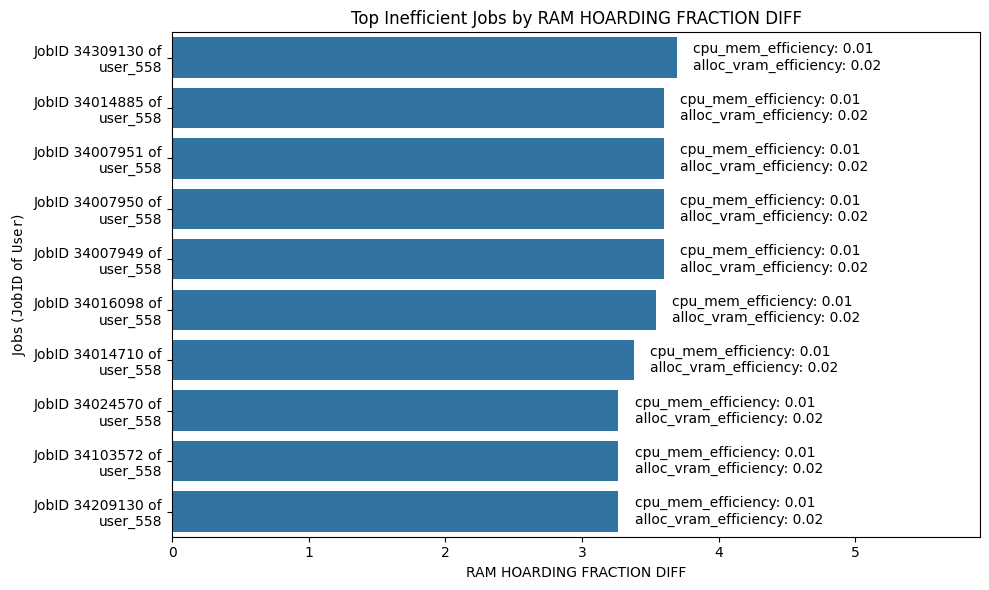

In [ ]:
inefficient_jobs_hoarding_ram = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.JOBS_WITH_RESOURCE_HOARDING_METRICS,
    sorting_key="ram_hoarding_fraction_diff",
    ascending=False,  # Sort in descending order
    filter_criteria={"ram_hoarding_fraction_diff": {"min": 0, "inclusive": True}},
)
# Plot top inefficient jobs by RAM hoarding fraction, with RAM hoarding fraction as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_hoarding_ram.head(10))
jobs_with_metrics_visualizer.visualize(
    column="ram_hoarding_fraction_diff",
    bar_label_columns=["cpu_mem_efficiency", "alloc_vram_efficiency"],
    figsize=(10, 6),
)

#### <a id='toc1_5_2_2_'></a>[Find most inefficient jobs hoarding CPU cores based on `core_hoarding_fraction_diff`](#toc0_)

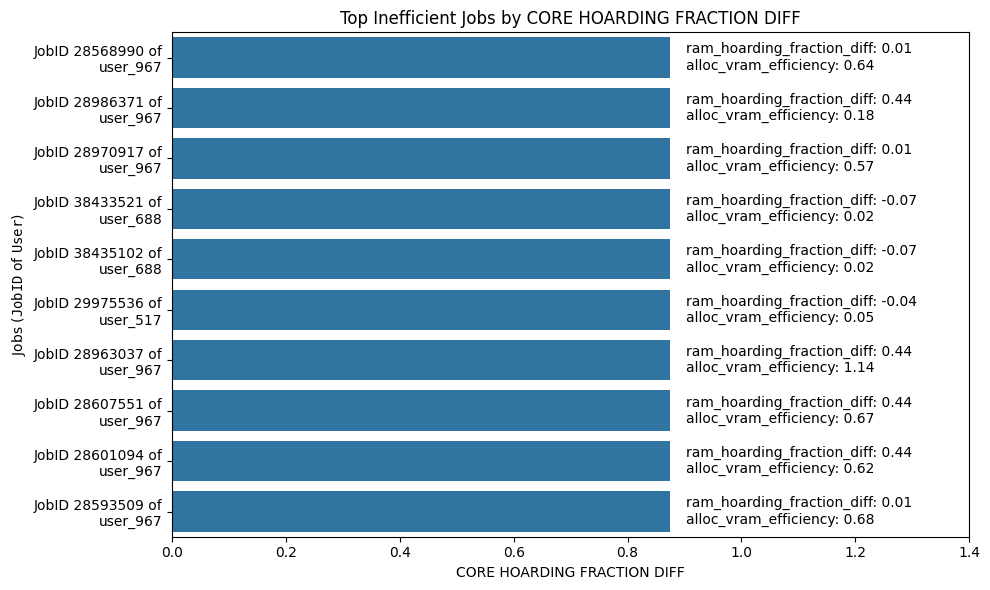

In [ ]:
inefficient_jobs_hoarding_cpu_cores = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.JOBS_WITH_RESOURCE_HOARDING_METRICS,
    sorting_key="core_hoarding_fraction_diff",
    ascending=False,  # Sort in descending order
    filter_criteria={
        "core_hoarding_fraction_diff": {"min": 0, "inclusive": True},
    },
)

# Plot top inefficient jobs by CPU core hoarding fraction, with CPU core hoarding fraction as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_hoarding_cpu_cores.head(10))
jobs_with_metrics_visualizer.visualize(
    column="core_hoarding_fraction_diff",
    bar_label_columns=["ram_hoarding_fraction_diff", "alloc_vram_efficiency"],
    figsize=(10, 6),
)

## <a id='toc1_6_'></a>[User-Level Analysis](#toc0_)

In [ ]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
0,user_01,312,2013.829722,account_288,-376.436134,-442.50696,0.435577,0.373203,1.316907,93344.522222
1,user_02,70,1561.586389,account_252,-1725.032831,-1674.612962,0.387995,0.395304,1.412745,83753.096944
2,user_03,230,3403.453889,account_05,-6831.720945,-6835.966556,0.21333,0.213116,3.604804,749146.912222
3,user_04,316,553.818889,account_125,-36.18073,-36.268811,0.779349,0.779009,1.014414,44560.546667
4,user_05,262,2910.031944,account_111,-994.735622,-984.302998,0.486316,0.490494,1.617360,249461.198333
...,...,...,...,...,...,...,...,...,...,...
603,user_990,773,3258.378333,account_50,-75.769932,-51.626191,0.892747,1.052512,1.000000,147719.920278
604,user_991,2779,2711.629722,account_272,-13.756767,-13.756767,0.418941,0.418941,1.000000,29827.926944
605,user_995,2,6.074444,account_111,-257.59135,-320.249221,0.206467,0.137164,1.000000,322.408889
606,user_996,6,3.301111,account_27,-126.160798,-117.050865,0.009706,0.013095,1.000000,161.798333


### <a id='toc1_6_1_'></a>[Find Inefficient Users based on `avg_requested_vram_efficiency_score`](#toc0_)

Minimum value for avg_requested_vram_efficiency_score: -264001.8796252523


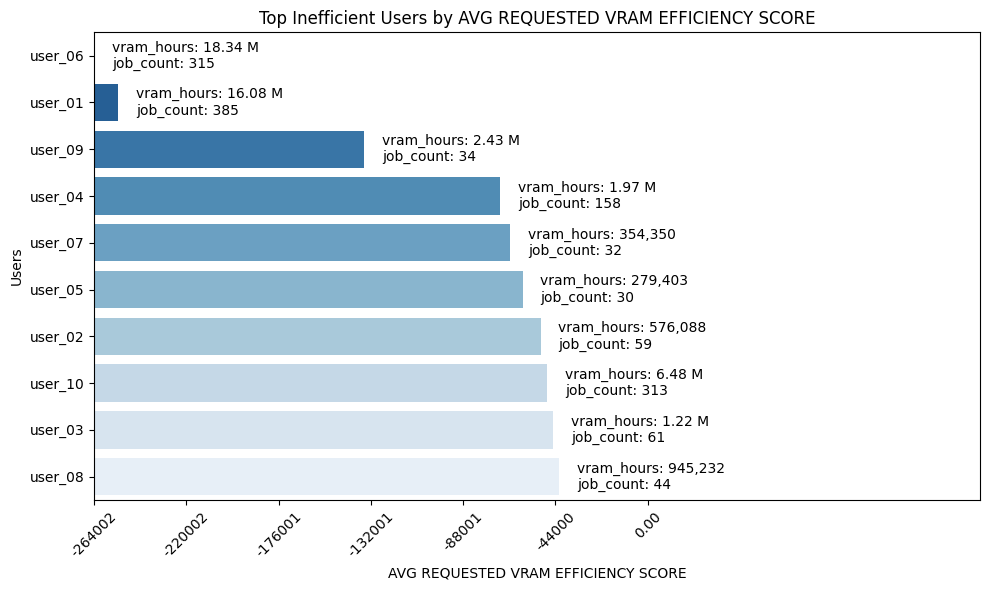

In [ ]:
inefficient_users_avg_req_vram_eff_score = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.USERS,
    sorting_key="avg_requested_vram_efficiency_score",
    ascending=True,  # Sort by avg_requested_vram_efficiency_score in ascending order
    filter_criteria={
        "avg_requested_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
        "job_count": {"min": 15, "inclusive": True},  # minimum job count threshold
    },
)
# Plot top inefficient users by Avg Requested VRAM Efficiency Score, with avg_requested_vram_efficiency_score as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_avg_req_vram_eff_score.head(10))
users_with_metrics_visualizer.visualize(
    column="avg_requested_vram_efficiency_score",
    bar_label_columns=["vram_hours", "job_count"],
    figsize=(10, 6),
    anonymize=True,
)

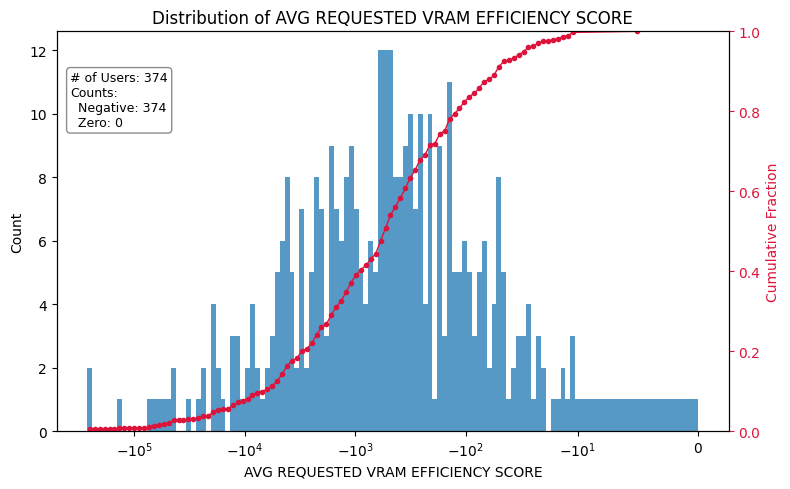

In [ ]:
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_avg_req_vram_eff_score)
users_with_metrics_visualizer.visualize_metric_distribution(
    output_dir_path=USERS_VISUALIZATION_DATA_DIR, column="avg_requested_vram_efficiency_score", figsize=(8, 5)
)

### <a id='toc1_6_2_'></a>[Find Inefficient Users based on EV(alloc_vram_efficiency)](#toc0_)

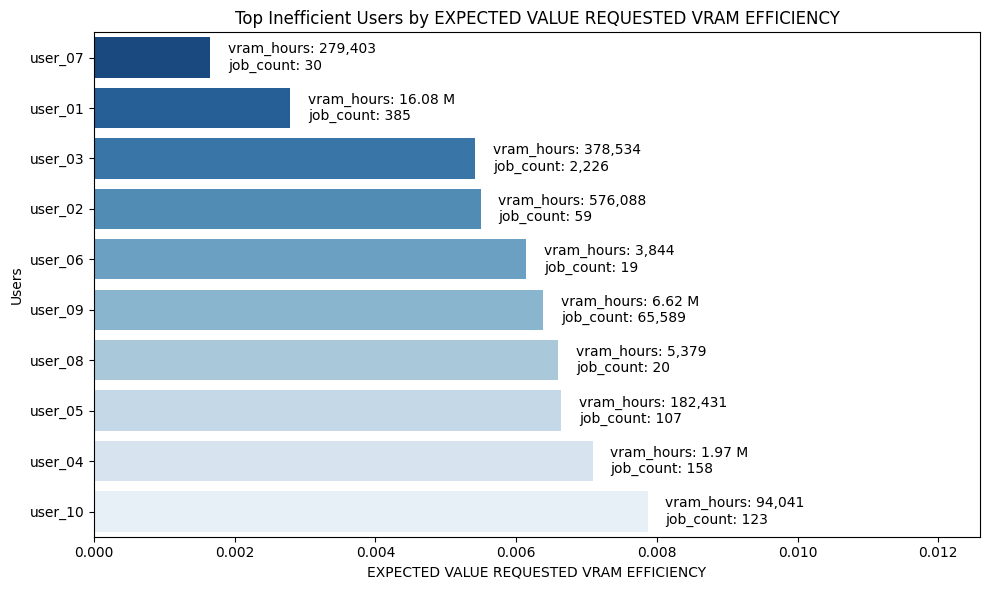

In [ ]:
inefficient_users_avg_req_vram_eff_score = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.USERS,
    sorting_key="expected_value_requested_vram_efficiency",
    ascending=True,  # Sort by expected_value_requested_vram_efficiency in ascending order
    filter_criteria={
        "job_count": {"min": 15, "inclusive": True},  # minimum job count threshold
    },
)
# Plot top inefficient users by Expected Value Requested VRAM Efficiency
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_avg_req_vram_eff_score.head(10))
users_with_metrics_visualizer.visualize(
    column="expected_value_requested_vram_efficiency",
    bar_label_columns=["vram_hours", "job_count"],
    figsize=(10, 6),
    anonymize=True,
)

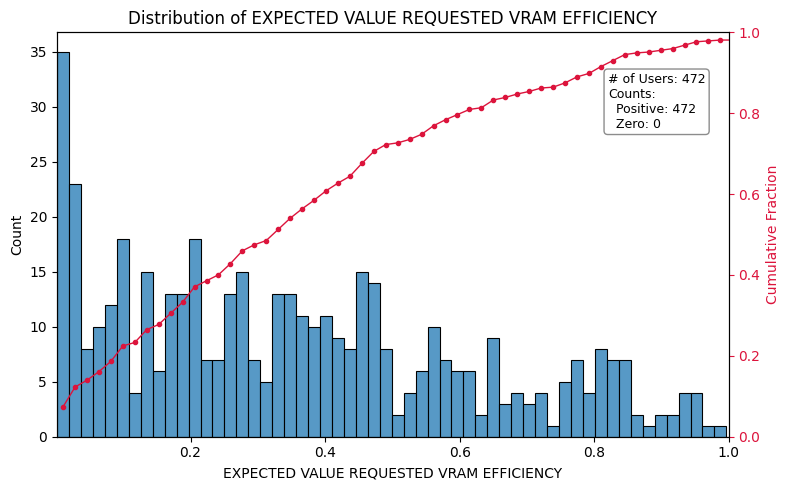

In [ ]:
inefficient_users_ev_req_vram_eff = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.USERS,
    sorting_key="expected_value_requested_vram_efficiency",
    ascending=True,  # Sort by expected_value_requested_vram_efficiency in ascending order
    filter_criteria={
        "job_count": {"min": 5, "inclusive": True},  # minimum job count threshold
    },
)
users_with_metrics_ev_visualizer = UsersWithMetricsVisualizer(inefficient_users_ev_req_vram_eff)
users_with_metrics_ev_visualizer.visualize_metric_distribution(
    output_dir_path=USERS_VISUALIZATION_DATA_DIR, column="expected_value_requested_vram_efficiency", figsize=(8, 5)
)

### <a id='toc1_6_3_'></a>[Generate all hoarding analysis metrics for users:](#toc0_)

In [ ]:
memory_hoarding_users = analyzer.calculate_node_resource_hoarding_for_users(filtered_jobs)
display(memory_hoarding_users)

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours,expected_value_ram_hoarding_fraction_diff,expected_value_core_hoarding_fraction_diff
0,user_01,312,2013.829722,account_288,-376.436134,-442.50696,0.435577,0.373203,1.316907,93344.522222,-0.186721,-0.164887
1,user_02,70,1561.586389,account_252,-1725.032831,-1674.612962,0.387995,0.395304,1.412745,83753.096944,0.083562,-0.074742
2,user_03,230,3403.453889,account_05,-6831.720945,-6835.966556,0.21333,0.213116,3.604804,749146.912222,-0.560113,-0.371193
3,user_04,316,553.818889,account_125,-36.18073,-36.268811,0.779349,0.779009,1.014414,44560.546667,-0.094646,-0.134397
4,user_05,262,2910.031944,account_111,-994.735622,-984.302998,0.486316,0.490494,1.617360,249461.198333,-0.092769,-0.132713
...,...,...,...,...,...,...,...,...,...,...,...,...
603,user_990,773,3258.378333,account_50,-75.769932,-51.626191,0.892747,1.052512,1.000000,147719.920278,-0.003888,-0.20525
604,user_991,2779,2711.629722,account_272,-13.756767,-13.756767,0.418941,0.418941,1.000000,29827.926944,0.020978,-0.082384
605,user_995,2,6.074444,account_111,-257.59135,-320.249221,0.206467,0.137164,1.000000,322.408889,-0.019613,-0.194199
606,user_996,6,3.301111,account_27,-126.160798,-117.050865,0.009706,0.013095,1.000000,161.798333,-0.140497,-0.139495


#### <a id='toc1_6_3_1_'></a>[Find most inefficient users hoarding node RAM based on `expected_value_ram_hoarding_fraction_diff`](#toc0_)

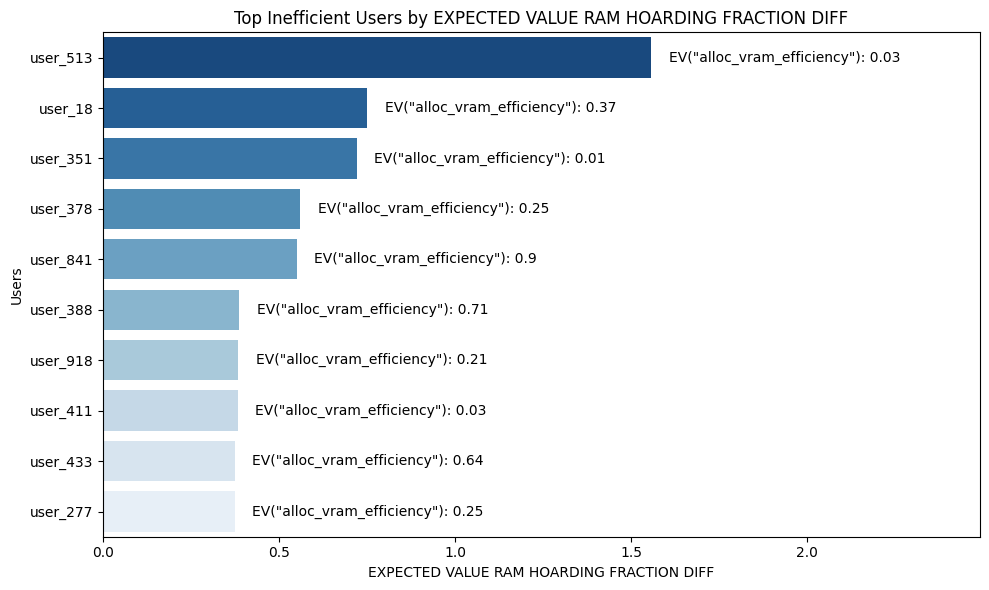

In [ ]:
inefficient_users_hoarding_ram = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.USERS_WITH_RESOURCE_HOARDING_METRICS,
    sorting_key="expected_value_ram_hoarding_fraction_diff",
    ascending=False,  # Sort in descending order
    filter_criteria={"expected_value_ram_hoarding_fraction_diff": {"min": 0, "inclusive": True}},
)
# Plot top inefficient users by RAM hoarding fraction, with RAM hoarding fraction as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_hoarding_ram.head(10))
users_with_metrics_visualizer.visualize(
    column="expected_value_ram_hoarding_fraction_diff",
    bar_label_columns=[
        "expected_value_alloc_vram_efficiency",
    ],
    figsize=(10, 6),
)

#### <a id='toc1_6_3_2_'></a>[Find most inefficient users hoarding CPU cores based on `expected_value_core_hoarding_fraction_diff`](#toc0_)

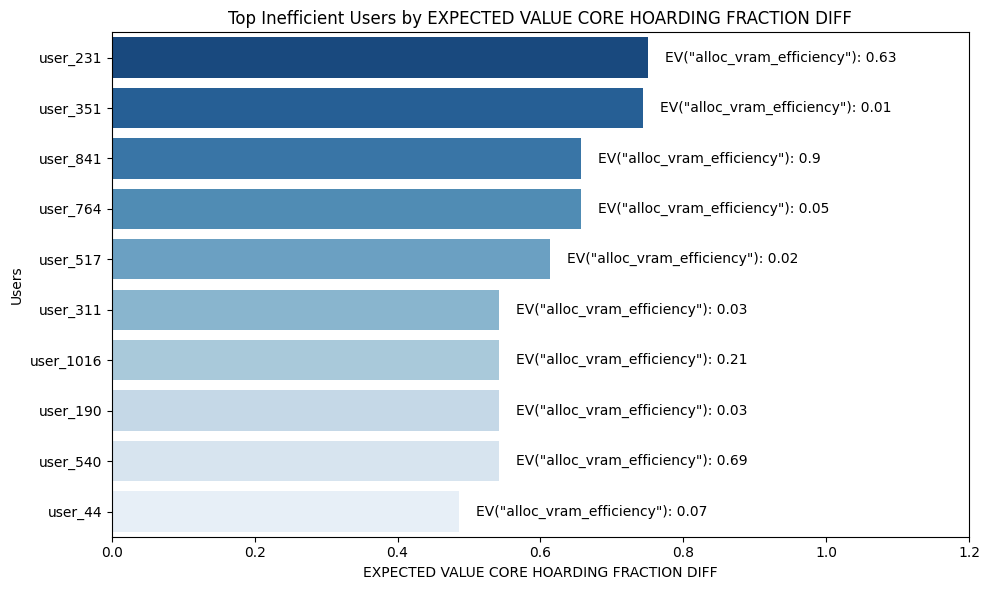

In [ ]:
inefficient_users_hoarding_cpu_cores = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.USERS_WITH_RESOURCE_HOARDING_METRICS,
    sorting_key="expected_value_core_hoarding_fraction_diff",
    ascending=False,  # Sort in descending order
    filter_criteria={"expected_value_core_hoarding_fraction_diff": {"min": 0, "inclusive": True}},
)
# Plot top inefficient users by CPU core hoarding fraction, with CPU core hoarding fraction as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_hoarding_cpu_cores.head(10))
users_with_metrics_visualizer.visualize(
    column="expected_value_core_hoarding_fraction_diff",
    bar_label_columns=[
        "expected_value_alloc_vram_efficiency",
    ],
    figsize=(10, 6),
)

## <a id='toc1_7_'></a>[PI Group Analysis](#toc0_)

In [ ]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count
0,account_90,2,1.134444,1,9.075556e+01,-220.562838,-220.562838,0.007890,0.007890,1.000000
1,account_41,23,169.768889,1,8.328682e+03,-1282.207141,-1362.21702,0.082993,0.081051,1.000000
2,account_02,5,8.562222,1,4.026889e+02,-396.930467,-365.620992,0.007700,0.011333,1.000000
3,account_21,73,3968.218333,2,2.617335e+05,-5152.786369,-4610.007878,0.296226,0.319388,1.000000
4,account_139,617,1156.088611,1,7.794813e+04,-162.267597,-180.323204,0.373144,0.341272,1.000000
...,...,...,...,...,...,...,...,...,...,...
175,account_268,2,25.034444,2,4.694364e+03,-10203.742195,-11382.264586,0.015735,0.010887,3.948761
176,account_59,41,184.175556,1,2.686353e+03,-216.874174,-216.874174,0.056281,0.056281,1.885030
177,account_237,2,16.006111,1,7.281631e+02,-177.966109,-177.966109,0.870793,0.870793,1.000000
178,account_278,107,194.784444,2,1.558672e+04,-104.899321,-117.506854,0.440610,0.436566,1.050669


#### <a id='toc1_7_1_1_'></a>[Find Inefficient PIs based on `avg_requested_vram_efficiency_score`](#toc0_)

Minimum value for avg_requested_vram_efficiency_score: -551714.4346574974


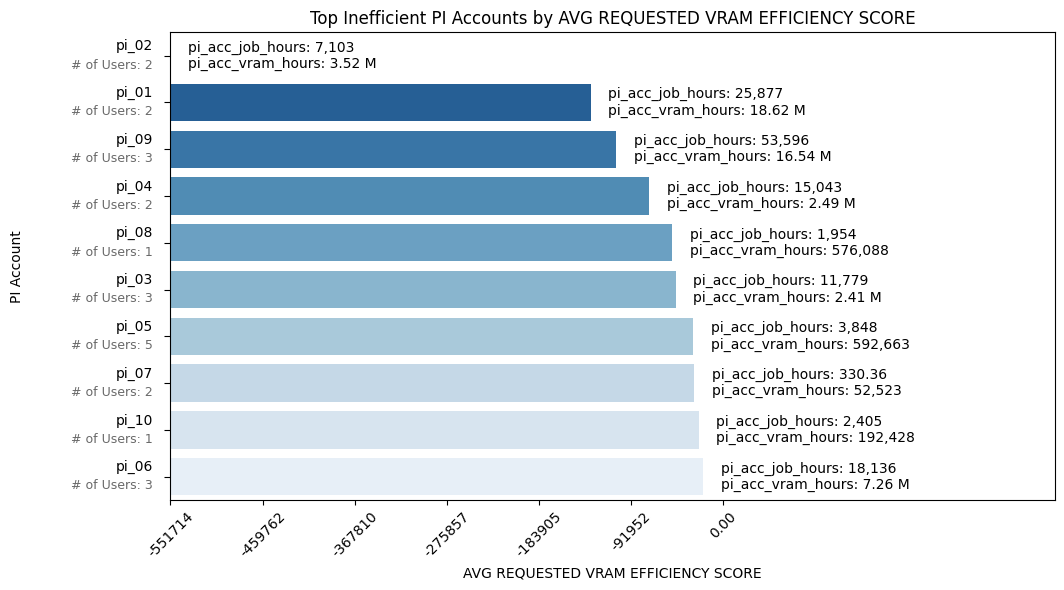

In [ ]:
inefficient_pis_avg_req_vram_eff_score = analyzer.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ResourceHoardingDataFrameNameEnum.PI_GROUPS,
    sorting_key="avg_requested_vram_efficiency_score",
    ascending=True,  # more negative first
    filter_criteria={
        "avg_requested_vram_efficiency_score": {"max": -10, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    },
)
pis_with_metrics_visualizer = PIGroupsWithMetricsVisualizer(inefficient_pis_avg_req_vram_eff_score.head(10))
pis_with_metrics_visualizer.visualize(
    output_dir_path=PI_GROUPS_VISUALIZATION_DATA_DIR,
    column="avg_requested_vram_efficiency_score",
    bar_label_columns=["pi_acc_job_hours", "pi_acc_vram_hours"],
    figsize=(10, 6),
    anonymize=True,
)